<a href="https://colab.research.google.com/github/HeyJae-zero/Final-Team9/blob/main/%EC%8B%9C%EB%A6%AC%EC%A6%88%EB%B3%84_%ED%9D%A5%ED%96%89%EC%B2%99%EB%8F%84_%EB%B6%84%EC%84%9D_%EC%8B%9C%EA%B0%81%ED%99%94.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### 사용한 통계 머신

1. 부호 검정: 누가 더 자주 이겼나를 보기 위해 사용 (승패 여부)
2. 윌콕슨: 얼마나 크게 이겼나를 보기 위해 사용 (크기 확인)

### 왜 비모수 검정을 사용했는가?
1. 이산형 데이터: y_result가 0~3의 순서형 척도
2. 제한된 값의 범위: 차이(diff)가 -3~3 사이의 정수만 가능
3. 순서형 특성: 등간격 가정이 애매함 (1점 차이 = 2점 차이?)
4. 분포의 치우침 가능성: 대부분 차이가 작을 가능성

### 결과표 보는 법

- sign test p값(one-sided): 후속이 더 자주 이기냐?
- wilcoxon p값(one-sided): 후속이 크게 이기는 경향도 있냐?
- diff 중앙값/평균: 평균적으로 얼마나 차이 나는지
- wins_sequel / wins_prior / ties_or_na: 후속 승/이전 승/비김의 숫자

In [19]:
# -*- coding: utf-8 -*-
"""
TMDB_processed_final_with_series.csv 기반
'계층적 비교(1→2, 2→3, …; 중간 없으면 1→3처럼 다음 유효 편과 비교)'에 대해
부호검정(Sign test)과 윌콕슨 부호순위검정(Wilcoxon signed-rank)을 함께 수행하여
방향(누가 더 우세?)과 차이의 크기(효과 크기, 중앙값/평균)를 모두 보여주는 스크립트.

- y_result 컬럼은 CSV에 이미 존재한다고 가정 (0~3의 순서형 점수)
- Avengers(1998)는 avengers 시리즈에서 제외
- 결과 저장(현재 작업 폴더):
    1) pairs_level_details.csv      : 모든 시리즈의 (i→j) 페어 상세 및 diff
    2) level_tests_summary.csv      : 각 전이 레벨(예: 1→2, 2→3, 1→3 등)별 검정 요약
    3) overall_tests_summary.csv    : 전체 페어에 대한 검정 요약
"""

import os
import math
import numpy as np
import pandas as pd
from datetime import datetime

# SciPy가 있으면 정확 검정 사용, 없으면 대체 절차(정규근사/부호검정)로 동작
try:
    from scipy.stats import binomtest, wilcoxon
    SCIPY = True
except Exception:
    SCIPY = False

# ---------- (0) 파일 로드 ----------
PATH = "/content/TMDB_processed_final_with_series.csv"
assert os.path.exists(PATH), f"파일이 없습니다: {PATH}"
df = pd.read_csv(PATH)

# ---------- (1) 컬럼명 설정 (필요시 아래만 수정) ----------
title_col = "title"
series_col = "series_group"
release_date_col = "release_date"
yresult_col = "y_result"

# ---------- (2) 연도 추출(정렬용) ----------
df["year_extracted"] = pd.to_datetime(df[release_date_col], errors="coerce").dt.year

# ---------- (3) Avengers(1998) 시리즈 제외 ----------
mask_avengers_1998 = (
    df[title_col].astype(str).str.strip().str.lower().eq("the avengers")
    & (df["year_extracted"] == 1998)
    & df[series_col].astype(str).str.lower().str.contains("avengers", na=False)
)
df.loc[mask_avengers_1998, series_col] = np.nan
print(f"[INFO] 'The Avengers (1998)' 시리즈 그룹 제외 행 수: {int(mask_avengers_1998.sum())}")

# ---------- (4) 시리즈 내 정렬 및 installment 부여 ----------
series_df = df[df[series_col].notna()].copy()
series_df = series_df.sort_values(
    by=[series_col, "year_extracted", release_date_col, title_col],
    ascending=[True, True, True, True],
)
series_df["installment"] = series_df.groupby(series_col).cumcount() + 1
series_df[yresult_col] = pd.to_numeric(series_df[yresult_col], errors="coerce")

# ---------- (5) '가장 가까운 다음 편'과 짝짓기
# 정렬된 순서에서 인접 행끼리 묶기 → 중간 편이 비어 있으면 자연스럽게 1→3 같은 페어가 만들어짐
pairs = []
for grp, g in series_df.groupby(series_col, sort=False):
    g = g.sort_values("installment")
    rows = list(g.itertuples(index=False))
    for a, b in zip(rows[:-1], rows[1:]):   # 인접 행끼리 페어링
        i_inst = int(getattr(a, "installment"))
        j_inst = int(getattr(b, "installment"))
        i_y = getattr(a, yresult_col)
        j_y = getattr(b, yresult_col)
        pairs.append({
            "series_group": grp,
            "i_installment": i_inst,
            "j_installment": j_inst,
            "level_label": f"{i_inst}->{j_inst}",  # 계층적 전이 라벨
            "i_title": getattr(a, title_col),
            "j_title": getattr(b, title_col),
            "i_year": int(getattr(a, "year_extracted")) if pd.notna(getattr(a, "year_extracted")) else None,
            "j_year": int(getattr(b, "year_extracted")) if pd.notna(getattr(b, "year_extracted")) else None,
            "i_y_result": i_y,
            "j_y_result": j_y,
        })

pairs_df = pd.DataFrame(pairs).dropna(subset=["i_y_result", "j_y_result"])
pairs_df["i_y_result"] = pairs_df["i_y_result"].astype(int)
pairs_df["j_y_result"] = pairs_df["j_y_result"].astype(int)
pairs_df["diff"] = pairs_df["j_y_result"] - pairs_df["i_y_result"]
pairs_df["win"] = np.where(pairs_df["diff"] > 0, 1, np.where(pairs_df["diff"] < 0, -1, 0))

print(f"[INFO] 생성된 계층 페어 수: {len(pairs_df)}")
if len(pairs_df) == 0:
    raise SystemExit("[ERROR] 유효한 페어가 없습니다. 시리즈/컬럼 구성을 확인해 주세요.")

# ---------- (6) 검정 함수 ----------
def sign_test(win_series):
    """부호검정(Sign test)을 이항검정으로 수행: H1: 후속 승 비율 > 0.5"""
    s = win_series.dropna()
    s = s[s != 0]  # 동률/NA 제외
    n_plus = int((s == 1).sum())
    n_minus = int((s == -1).sum())
    n = n_plus + n_minus
    if n == 0:
        return {"n_eff": 0, "wins_sequel": n_plus, "wins_prior": n_minus, "p_one": np.nan, "p_two": np.nan}
    if SCIPY:
        p_two = binomtest(n_plus, n, 0.5, alternative="two-sided").pvalue
        p_one = binomtest(n_plus, n, 0.5, alternative="greater").pvalue
    else:
        # 정규근사(간이)
        phat = n_plus / n
        se = math.sqrt(0.25 / n)
        z = (phat - 0.5) / se
        p_one = 0.5 * (1 - math.erf(z / math.sqrt(2)))
        p_two = min(1.0, 2 * p_one)
    return {"n_eff": n, "wins_sequel": n_plus, "wins_prior": n_minus, "p_one": p_one, "p_two": p_two}

def wilcoxon_or_sign(diff_series):
    """Wilcoxon 한쪽/양쪽 p; SciPy 없으면 부호검정 대체"""
    d = diff_series.dropna()
    d = d[d != 0]
    if len(d) == 0:
        return {"n_eff": 0, "stat": np.nan, "p_one": np.nan, "p_two": np.nan}
    if SCIPY:
        stat_g, p_one = wilcoxon(d, alternative="greater", zero_method="wilcox")
        stat_t, p_two = wilcoxon(d, alternative="two-sided", zero_method="wilcox")
        return {"n_eff": int(len(d)), "stat": float(stat_g), "p_one": float(p_one), "p_two": float(p_two)}
    else:
        # 부호검정으로 대체
        n_plus = int((d > 0).sum()); n_minus = int((d < 0).sum()); n = n_plus + n_minus
        if n == 0:
            return {"n_eff": 0, "stat": np.nan, "p_one": np.nan, "p_two": np.nan}
        phat = n_plus / n
        se = math.sqrt(0.25 / n)
        z = (phat - 0.5) / se
        p_one = 0.5 * (1 - math.erf(z / math.sqrt(2)))
        p_two = min(1.0, 2 * p_one)
        return {"n_eff": n, "stat": np.nan, "p_one": p_one, "p_two": p_two}

def summarize_block(block_df, label="OVERALL"):
    """한 전이 레벨(예: 1→2) 또는 전체에 대해 Sign/Wilcoxon + 효과크기 요약"""
    wins = block_df["win"].fillna(0)
    sign_res = sign_test(wins)

    wres = wilcoxon_or_sign(block_df["diff"])

    # 효과 크기(차이의 크기) 요약: 중앙값/평균/표준편차, 양/음/0 개수
    diff = block_df["diff"]
    diff_nz = diff[diff != 0].dropna()
    summary = {
        "level_label": label,
        "pairs_total": int(len(block_df)),
        "pairs_used_sign": int(sign_res["n_eff"]),
        "pairs_used_wilcoxon": int(wres["n_eff"]),
        "wins_sequel": int(sign_res["wins_sequel"]),
        "wins_prior": int(sign_res["wins_prior"]),
        "ties_or_na": int((wins == 0).sum()),
        "diff_median": float(np.nanmedian(diff)) if len(diff) > 0 else np.nan,
        "diff_mean": float(np.nanmean(diff)) if len(diff) > 0 else np.nan,
        "diff_std": float(np.nanstd(diff, ddof=1)) if len(diff) > 1 else np.nan,
        "diff_pos_count": int((diff > 0).sum()),
        "diff_neg_count": int((diff < 0).sum()),
        "diff_zero_count": int((diff == 0).sum()),
        "sign_p_one_sided(H1: sequel > prior)": sign_res["p_one"],
        "sign_p_two_sided": sign_res["p_two"],
        "wilcoxon_stat": wres["stat"],
        "wilcoxon_p_one_sided(H1: sequel > prior)": wres["p_one"],
        "wilcoxon_p_two_sided": wres["p_two"],
    }
    return summary

# ---------- (7) 레벨별 요약 ----------
level_summaries = []
for lvl, g in pairs_df.groupby("level_label", sort=False):
    level_summaries.append(summarize_block(g, label=lvl))

level_summary_df = pd.DataFrame(level_summaries).sort_values(
    by=["level_label", "pairs_total"], ascending=[True, False]
)

# ---------- (8) 전체(OVERALL) 요약 ----------
overall_summary_df = pd.DataFrame([summarize_block(pairs_df, label="OVERALL")])

# ---------- (9) 저장 ----------
pairs_df.to_csv("pairs_level_details.csv", index=False)
level_summary_df.to_csv("level_tests_summary.csv", index=False)
overall_summary_df.to_csv("overall_tests_summary.csv", index=False)

print("[저장 완료] pairs_level_details.csv")
print("[저장 완료] level_tests_summary.csv")
print("[저장 완료] overall_tests_summary.csv")

# ---------- (10) 콘솔 표시(요약) ----------
print("\n=== OVERALL SUMMARY ===")
print(overall_summary_df.to_string(index=False))

print("\n=== LEVEL SUMMARY (head) ===")
print(level_summary_df.head(20).to_string(index=False))

[INFO] 'The Avengers (1998)' 시리즈 그룹 제외 행 수: 1
[INFO] 생성된 계층 페어 수: 362
[저장 완료] pairs_level_details.csv
[저장 완료] level_tests_summary.csv
[저장 완료] overall_tests_summary.csv

=== OVERALL SUMMARY ===
level_label  pairs_total  pairs_used_sign  pairs_used_wilcoxon  wins_sequel  wins_prior  ties_or_na  diff_median  diff_mean  diff_std  diff_pos_count  diff_neg_count  diff_zero_count  sign_p_one_sided(H1: sequel > prior)  sign_p_two_sided  wilcoxon_stat  wilcoxon_p_one_sided(H1: sequel > prior)  wilcoxon_p_two_sided
    OVERALL          362              155                  155           38         117         207          0.0  -0.298343  0.845026              38             117              207                                   1.0      1.478869e-10         2746.0                                       1.0          3.605934e-10

=== LEVEL SUMMARY (head) ===
level_label  pairs_total  pairs_used_sign  pairs_used_wilcoxon  wins_sequel  wins_prior  ties_or_na  diff_median  diff_mean  diff_std  diff_p

In [20]:
# Colab: 한글 폰트 설치 & 캐시 재생성
!apt-get -y install fonts-noto-cjk fonts-nanum > /dev/null
!rm -rf ~/.cache/matplotlib
!fc-cache -fv > /dev/null

import matplotlib as mpl, matplotlib.font_manager as fm

# 사용 가능한 한글 폰트 중 우선순위 선택
available = {f.name for f in fm.fontManager.ttflist}
for name in ["Noto Sans CJK KR", "NanumGothic", "Noto Sans CJK JP", "Noto Sans CJK SC"]:
    if name in available:
        mpl.rcParams["font.family"] = name
        break
else:
    mpl.rcParams["font.family"] = "DejaVu Sans"  # 최후 fallback

mpl.rcParams["axes.unicode_minus"] = False
mpl.rcParams["pdf.fonttype"] = 42
mpl.rcParams["ps.fonttype"]  = 42

print("Using font:", mpl.rcParams["font.family"])


Using font: ['DejaVu Sans']


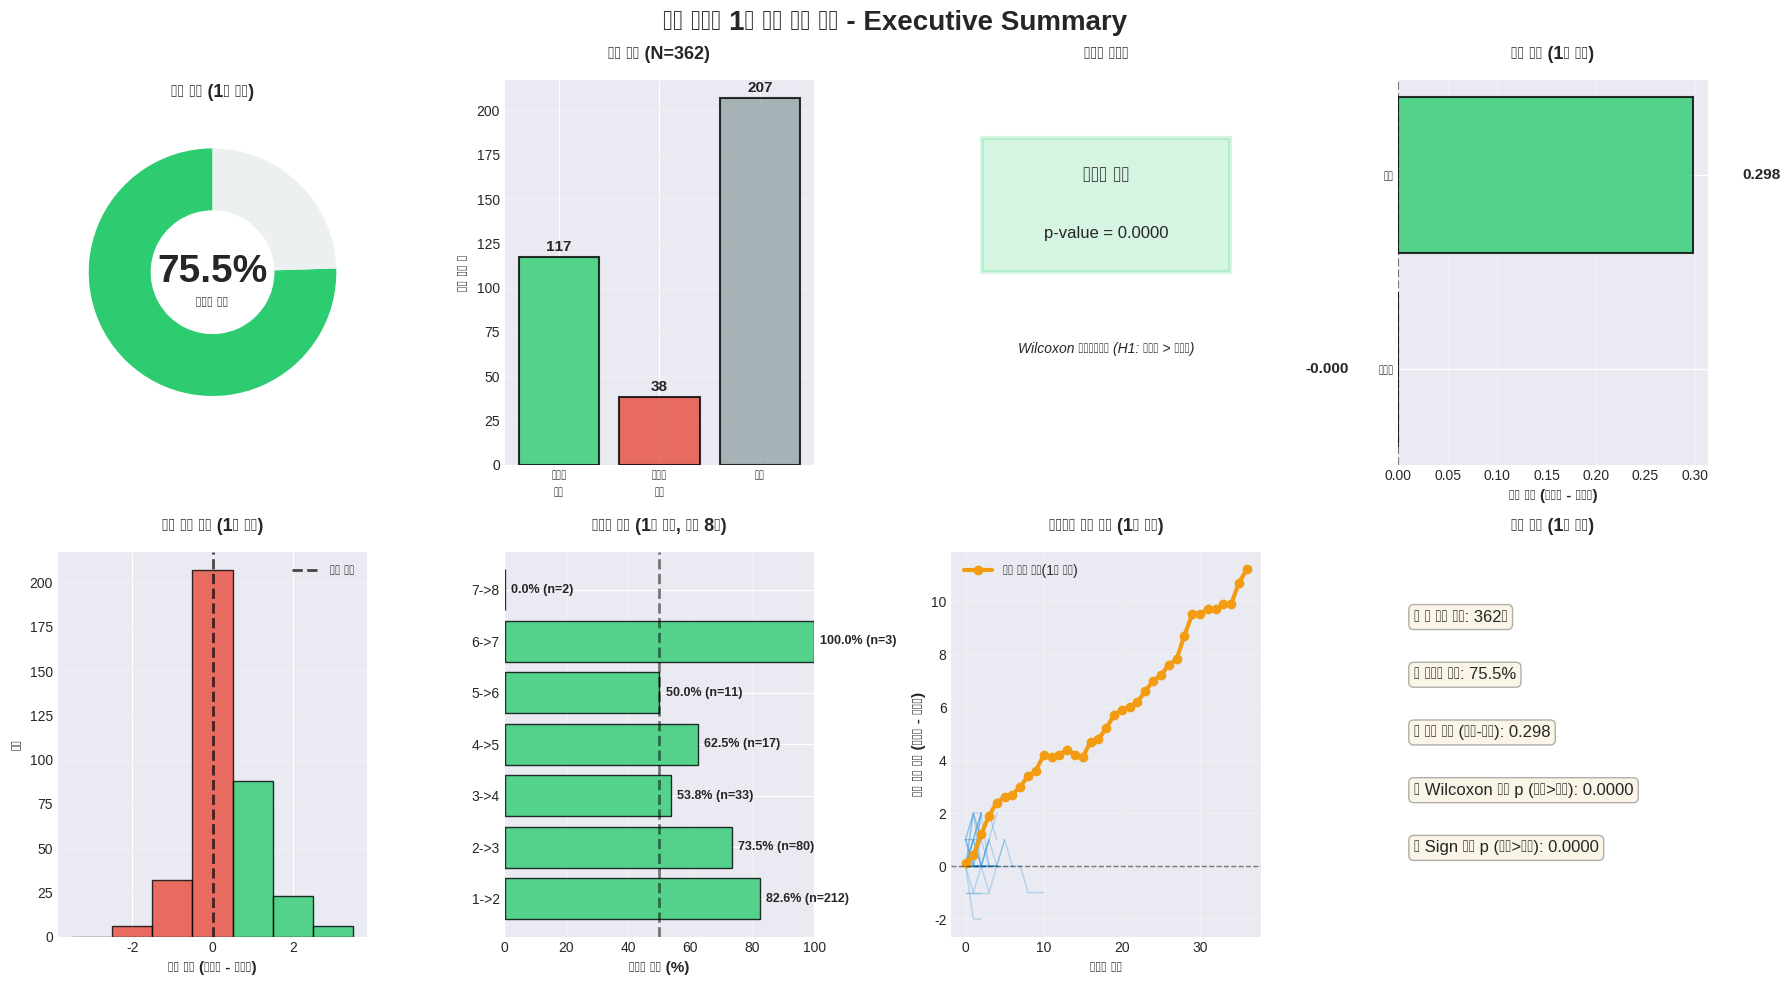

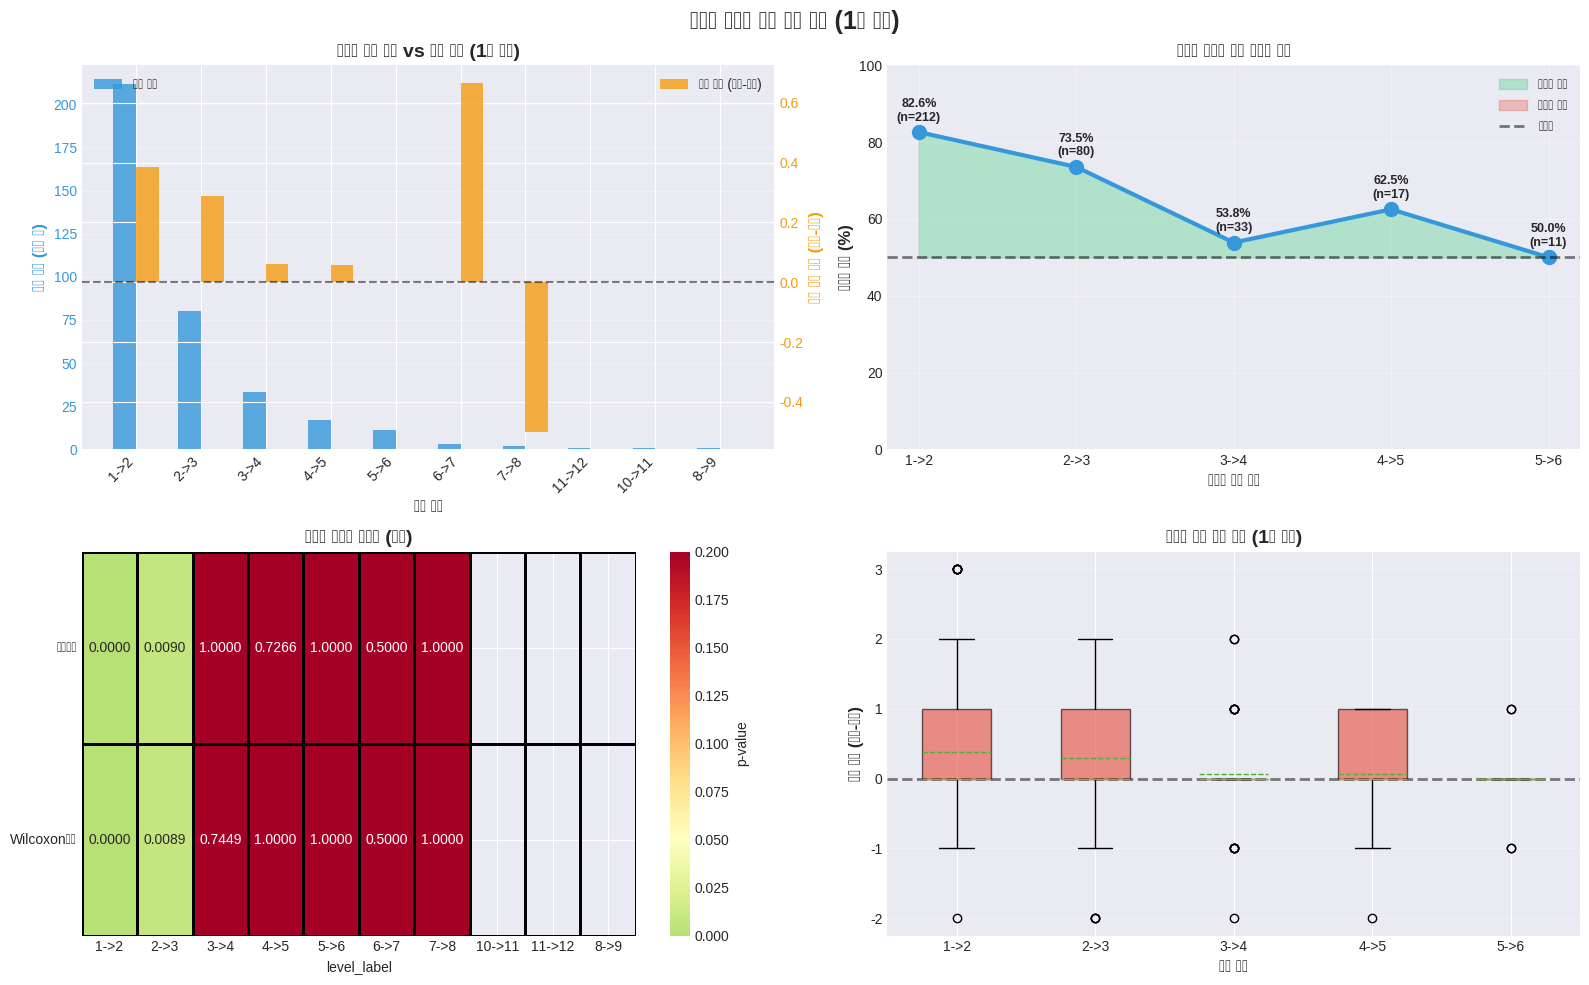

== Done ==
Saved: /content/executive_summary.png & /content/detailed_level_analysis.png


In [21]:
"""
프로페셔널 투자 프레젠테이션용 시각화 (Colab, 1편 관점 / 한글 안전 버전)
"""

# 1) 라이브러리 & 스타일
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from matplotlib.patches import Rectangle
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# 2) 데이터 로드 (/content에 csv 3개 업로드)
BASE = "/content"
pairs_df = pd.read_csv(f"{BASE}/pairs_level_details.csv")
level_summary_df = pd.read_csv(f"{BASE}/level_tests_summary.csv")
overall_summary_df = pd.read_csv(f"{BASE}/overall_tests_summary.csv")

# 3) 관점 전환: '이전편 - 후속편'
pairs_df['prior_view_diff'] = -pairs_df['diff']
overall_summary_df['prior_view_diff_mean']   = -overall_summary_df['diff_mean']
overall_summary_df['prior_view_diff_median'] = -overall_summary_df['diff_median']

# 색상
COLOR_POSITIVE = '#2ECC71'   # 이전편 유리(긍정)
COLOR_NEGATIVE = '#E74C3C'   # 후속편 유리(부정)
COLOR_NEUTRAL  = '#95A5A6'
COLOR_PRIMARY  = '#3498DB'
COLOR_ACCENT   = '#F39C12'

# 4) Executive Summary (4x2)
fig = plt.figure(figsize=(18, 10))
fig.suptitle('영화 시리즈 1편 관점 성과 분석 - Executive Summary',
             fontsize=20, fontweight='bold', y=0.98)

total      = overall_summary_df['pairs_total'].iloc[0]
wins_seq   = overall_summary_df['wins_sequel'].iloc[0]
wins_prior = overall_summary_df['wins_prior'].iloc[0]
ties_or_na = overall_summary_df['ties_or_na'].iloc[0]
win_rate_prior = wins_prior / (wins_prior + wins_seq) * 100

# 단측 p-value 방향 반전 (원본: H1=sequel>prior)
p_wilcox_seq_gt_prior = overall_summary_df['wilcoxon_p_one_sided(H1: sequel > prior)'].iloc[0]
p_sign_seq_gt_prior   = overall_summary_df['sign_p_one_sided(H1: sequel > prior)'].iloc[0]
p_wilcox_prior_gt_seq = 1.0 - p_wilcox_seq_gt_prior
p_sign_prior_gt_seq   = 1.0 - p_sign_seq_gt_prior

# 4-1. 이전편 승률 도넛
ax1 = plt.subplot(2,4,1)
sizes = [win_rate_prior, 100 - win_rate_prior]
colors_donut = [COLOR_POSITIVE if win_rate_prior >= 50 else COLOR_NEGATIVE, '#ECF0F1']
ax1.pie(sizes, startangle=90, colors=colors_donut, wedgeprops=dict(width=0.5))
ax1.text(0, 0, f'{win_rate_prior:.1f}%', ha='center', va='center', fontsize=28, fontweight='bold')
ax1.text(0, -0.25, '이전편 승률', ha='center', va='center', fontsize=11)
ax1.set_title('전체 성과 (1편 관점)', fontsize=13, fontweight='bold', pad=15)

# 4-2. 분포 막대
ax2 = plt.subplot(2,4,2)
categories = ['이전편\n승리', '후속편\n승리', '동률']
values = [wins_prior, wins_seq, ties_or_na]
bars = ax2.bar(categories, values,
               color=[COLOR_POSITIVE, COLOR_NEGATIVE, COLOR_NEUTRAL],
               alpha=0.8, edgecolor='black', linewidth=1.5)
for b,v in zip(bars,values):
    ax2.text(b.get_x()+b.get_width()/2, b.get_height()+2, str(v),
             ha='center', va='bottom', fontsize=11, fontweight='bold')
ax2.set_ylabel('영화 페어 수', fontsize=11, fontweight='bold')
ax2.set_title(f'전체 분포 (N={total})', fontsize=13, fontweight='bold', pad=15)
ax2.grid(axis='y', alpha=0.3)

# 4-3. 통계적 유의성(단측: 이전>후속)
ax3 = plt.subplot(2,4,3); ax3.axis('off')
box_color = COLOR_POSITIVE if p_wilcox_prior_gt_seq < 0.05 else COLOR_NEGATIVE
ax3.add_patch(Rectangle((0.1, 0.5), 0.8, 0.35,
                        facecolor=box_color, alpha=0.2,
                        edgecolor=box_color, linewidth=3))
sig_text = "통계적 유의" if p_wilcox_prior_gt_seq < 0.05 else "유의하지 않음"
ax3.text(0.5, 0.75, sig_text, ha='center', va='center', fontsize=16, fontweight='bold',
         transform=ax3.transAxes)
ax3.text(0.5, 0.6, f'p-value = {p_wilcox_prior_gt_seq:.4f}', ha='center', va='center',
         fontsize=12, transform=ax3.transAxes)
ax3.text(0.5, 0.3, 'Wilcoxon 부호순위검정 (H1: 이전편 > 후속편)',
         ha='center', va='center', fontsize=10, style='italic', transform=ax3.transAxes)
ax3.set_title('통계적 유의성', fontsize=13, fontweight='bold', pad=15)

# 4-4. 효과 크기 (이전-후속)
ax4 = plt.subplot(2,4,4)
diff_med_prior  = overall_summary_df['prior_view_diff_median'].iloc[0]
diff_mean_prior = overall_summary_df['prior_view_diff_mean'].iloc[0]
bars = ax4.barh(['중앙값','평균'], [diff_med_prior, diff_mean_prior],
                color=[COLOR_POSITIVE if v>0 else COLOR_NEGATIVE for v in [diff_med_prior, diff_mean_prior]],
                alpha=0.8, edgecolor='black', linewidth=1.5)
for b,v in zip(bars,[diff_med_prior, diff_mean_prior]):
    ax4.text(v + (0.05 if v>0 else -0.05), b.get_y()+b.get_height()/2, f'{v:.3f}',
             ha='left' if v>0 else 'right', va='center', fontsize=11, fontweight='bold')
ax4.axvline(0, color='black', linestyle='--', alpha=0.5)
ax4.set_xlabel('점수 차이 (이전편 - 후속편)', fontsize=11, fontweight='bold')
ax4.set_title('효과 크기 (1편 관점)', fontsize=13, fontweight='bold', pad=15)
ax4.grid(axis='x', alpha=0.3)

# 4-5. 차이 분포
ax5 = plt.subplot(2,4,5)
diff_values = pairs_df['prior_view_diff'].dropna()
bins = np.arange(-3.5, 4.5, 1)
n, bins_out, patches = ax5.hist(diff_values, bins=bins, alpha=0.8,
                                edgecolor='black', linewidth=1)
for p,c in zip(patches, [COLOR_NEGATIVE if x<0 else (COLOR_NEUTRAL if x==0 else COLOR_POSITIVE) for x in bins[:-1]]):
    p.set_facecolor(c)
ax5.axvline(0, color='black', linestyle='--', linewidth=2, alpha=0.7, label='변화 없음')
ax5.set_xlabel('점수 차이 (이전편 - 후속편)', fontsize=11, fontweight='bold')
ax5.set_ylabel('빈도', fontsize=11, fontweight='bold')
ax5.set_title('성과 차이 분포 (1편 관점)', fontsize=13, fontweight='bold', pad=15)
ax5.legend(); ax5.grid(axis='y', alpha=0.3)

# 4-6. 레벨별 이전편 승률
ax6 = plt.subplot(2,4,6)
level_summary_df['win_rate_prior'] = (
    level_summary_df['wins_prior'] /
    (level_summary_df['wins_prior'] + level_summary_df['wins_sequel']) * 100
)
top_levels = level_summary_df.nlargest(8, 'pairs_total')
bars = ax6.barh(top_levels['level_label'], top_levels['win_rate_prior'],
                color=[COLOR_POSITIVE if wr>=50 else COLOR_NEGATIVE for wr in top_levels['win_rate_prior']],
                alpha=0.8, edgecolor='black', linewidth=1)
ax6.axvline(50, color='black', linestyle='--', linewidth=2, alpha=0.5)
for b, val, cnt in zip(bars, top_levels['win_rate_prior'], top_levels['pairs_total']):
    ax6.text(val + 2, b.get_y()+b.get_height()/2, f'{val:.1f}% (n={cnt})',
             va='center', fontsize=9, fontweight='bold')
ax6.set_xlabel('이전편 승률 (%)', fontsize=11, fontweight='bold')
ax6.set_xlim(0, 100)
ax6.set_title('레벨별 성과 (1편 관점, 상위 8개)', fontsize=13, fontweight='bold', pad=15)
ax6.grid(axis='x', alpha=0.3)

# 4-7. 누적 성과 (1편 관점)
ax7 = plt.subplot(2,4,7)
pairs_df_sorted = pairs_df.sort_values(['series_group', 'i_installment']).copy()
pairs_df_sorted['cumulative_prior_view'] = pairs_df_sorted.groupby('series_group')['prior_view_diff'].cumsum()
for series, grp in pairs_df_sorted.groupby('series_group'):
    if len(grp) >= 3:
        ax7.plot(range(len(grp)), grp['cumulative_prior_view'], alpha=0.3, linewidth=1, color=COLOR_PRIMARY)
overall_cumsum = pairs_df_sorted.groupby(pairs_df_sorted.index // 10)['prior_view_diff'].mean().cumsum()
ax7.plot(range(len(overall_cumsum)), overall_cumsum, color=COLOR_ACCENT, linewidth=3,
         label='전체 평균 추세(1편 관점)', marker='o')
ax7.axhline(0, color='black', linestyle='--', linewidth=1, alpha=0.5)
ax7.set_xlabel('후속편 순서', fontsize=11, fontweight='bold')
ax7.set_ylabel('누적 성과 차이 (이전편 - 후속편)', fontsize=11, fontweight='bold')
ax7.set_title('시리즈별 누적 성과 (1편 관점)', fontsize=13, fontweight='bold', pad=15)
ax7.legend(); ax7.grid(alpha=0.3)

# 4-8. Key Insights (모노스페이스 지정 제거)
ax8 = plt.subplot(2,4,8); ax8.axis('off')
insights = [
    f"✓ 총 분석 페어: {total}개",
    f"✓ 이전편 승률: {win_rate_prior:.1f}%",
    f"✓ 평균 차이 (이전-후속): {diff_mean_prior:.3f}",
    f"✓ Wilcoxon 단측 p (이전>후속): {p_wilcox_prior_gt_seq:.4f}",
    f"✓ Sign 단측 p (이전>후속): {p_sign_prior_gt_seq:.4f}",
]
y = 0.85
for t in insights:
    ax8.text(0.05, y, t, transform=ax8.transAxes, fontsize=12,
             verticalalignment='top',
             bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.3))
    y -= 0.15
ax8.set_title('핵심 지표 (1편 관점)', fontsize=13, fontweight='bold', pad=15)

import os
plt.tight_layout()
plt.savefig(f"{BASE}/executive_summary.png", dpi=300, bbox_inches='tight')
plt.show()

# 5) 상세 분석 (1편 관점)
fig2, axes = plt.subplots(2, 2, figsize=(16, 10))
fig2.suptitle('후속편 레벨별 상세 성과 분석 (1편 관점)', fontsize=18, fontweight='bold')

# 5-1. 샘플 크기 vs 효과 크기
ax = axes[0,0]
level_sorted = level_summary_df.sort_values('pairs_total', ascending=False).head(10).copy()
x = np.arange(len(level_sorted)); w = 0.35
ax.bar(x - w/2, level_sorted['pairs_total'], w, label='샘플 크기',
       color=COLOR_PRIMARY, alpha=0.8)
ax2 = ax.twinx()
ax2.bar(x + w/2, -level_sorted['diff_mean'], w, label='평균 차이 (이전-후속)',
        color=COLOR_ACCENT, alpha=0.8)
ax.set_xlabel('전이 레벨', fontsize=12, fontweight='bold')
ax.set_ylabel('샘플 크기 (페어 수)', fontsize=12, fontweight='bold', color=COLOR_PRIMARY)
ax2.set_ylabel('평균 성과 차이 (이전-후속)', fontsize=12, fontweight='bold', color=COLOR_ACCENT)
ax.set_xticks(x); ax.set_xticklabels(level_sorted['level_label'], rotation=45, ha='right')
ax.tick_params(axis='y', labelcolor=COLOR_PRIMARY); ax2.tick_params(axis='y', labelcolor=COLOR_ACCENT)
ax2.axhline(0, color='black', linestyle='--', alpha=0.5)
ax.legend(loc='upper left'); ax2.legend(loc='upper right')
ax.set_title('레벨별 샘플 크기 vs 효과 크기 (1편 관점)', fontsize=14, fontweight='bold')
ax.grid(axis='y', alpha=0.3)

# 5-2. 승률 추세
ax = axes[0,1]
level_order = ['1->2','2->3','3->4','4->5','5->6']
lv = level_summary_df[level_summary_df['level_label'].isin(level_order)].copy()
lv['level_label'] = pd.Categorical(lv['level_label'], categories=level_order, ordered=True)
lv = lv.sort_values('level_label')
if len(lv)>0:
    ax.plot(lv['level_label'], lv['win_rate_prior'], marker='o', markersize=10,
            linewidth=3, color=COLOR_PRIMARY)
    ax.fill_between(range(len(lv)), lv['win_rate_prior'], 50,
                    where=(lv['win_rate_prior']>=50), color=COLOR_POSITIVE, alpha=0.3, label='이전편 우세')
    ax.fill_between(range(len(lv)), lv['win_rate_prior'], 50,
                    where=(lv['win_rate_prior']<50), color=COLOR_NEGATIVE, alpha=0.3, label='후속편 우세')
    ax.axhline(50, color='black', linestyle='--', linewidth=2, alpha=0.5, label='균형점')
    for i, (label, rate, cnt) in enumerate(zip(lv['level_label'], lv['win_rate_prior'], lv['pairs_total'])):
        ax.text(i, rate+3, f'{rate:.1f}%\n(n={cnt})', ha='center', fontsize=9, fontweight='bold')
ax.set_xlabel('시리즈 진행 단계', fontsize=12, fontweight='bold')
ax.set_ylabel('이전편 승률 (%)', fontsize=12, fontweight='bold')
ax.set_ylim(0, 100); ax.set_title('시리즈 진행에 따른 이전편 승률', fontsize=14, fontweight='bold')
ax.legend(); ax.grid(alpha=0.3)

# 5-3. 레벨별 p-value(양측)
ax = axes[1,0]
top10 = level_summary_df.nlargest(10, 'pairs_total')
mat = top10[['sign_p_two_sided','wilcoxon_p_two_sided']].T
mat.columns = top10['level_label']
sns.heatmap(mat, annot=True, fmt='.4f', cmap='RdYlGn_r',
            center=0.05, vmin=0, vmax=0.2, cbar_kws={'label':'p-value'},
            linewidths=2, linecolor='black', ax=ax)
ax.set_yticklabels(['부호검정','Wilcoxon검정'], rotation=0)
ax.set_title('레벨별 통계적 유의성 (양측)', fontsize=14, fontweight='bold')

# 5-4. 박스플롯 (이전-후속)
ax = axes[1,1]
top5 = level_summary_df.nlargest(5, 'pairs_total')['level_label'].tolist()
data_for_box, labels_for_box = [], []
for lv_label in top5:
    s = pairs_df[pairs_df['level_label']==lv_label]['prior_view_diff'].dropna()
    if len(s)>0: data_for_box.append(s); labels_for_box.append(lv_label)
bp = ax.boxplot(data_for_box, labels=labels_for_box, patch_artist=True, showmeans=True, meanline=True)
for patch, med in zip(bp['boxes'], bp['medians']):
    med_val = med.get_ydata()[0]
    patch.set_facecolor(COLOR_POSITIVE if med_val>0 else COLOR_NEGATIVE); patch.set_alpha(0.6)
ax.axhline(0, color='black', linestyle='--', linewidth=2, alpha=0.5)
ax.set_xlabel('전이 레벨', fontsize=12, fontweight='bold')
ax.set_ylabel('성과 차이 (이전-후속)', fontsize=12, fontweight='bold')
ax.set_title('레벨별 성과 차이 분포 (1편 관점)', fontsize=14, fontweight='bold')
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig(f"{BASE}/detailed_level_analysis.png", dpi=300, bbox_inches='tight')
plt.show()

print("== Done ==")
print("Saved:", f"{BASE}/executive_summary.png", "&", f"{BASE}/detailed_level_analysis.png")
